# SPS Python Tutorial, Day 1
---
*January 29/30, 2020*

Luc Le Pottier, University of Michigan

## **3: visualization**
Now we cover some of the most useful data visualization and plotting utilities, such as
- the `matplotlib` module:
    - baseline interface for all plotting; super customizable
    - can be annoying to get everything *just right*
- `seaborn` wrapper module for `matplotlib`:
    - very intuitive, works with `pandas` quite nicely
    - automatically finds pretty formatting
    - less customizable
- `pandas` plotting functions within the `DataFrame` object
    - good for quick data inspection
- the `corner` module
    - `corner` and other modules like it provide quick implementations of hard-to-write functions; in this case, corner plots
    - huge positive side to the open-source nature of python 

In [ ]:
# custom distributions
x = np.linspace(0.0, 10.0, 1E4)

def p(x):
	return (x**3)/(np.exp(2.0 * x) - 0.1)

# Define function to normalise the PDF
def normalisation(x):
	return simps(p(x), x)

# Define the distribution using rv_continuous
class blackbody(ss.rv_continuous): 
    def _pdf(self, x, const):
        return (1.0/const) * p(x)
    
own_pdf = p(x)/norm_constant
own_cdf = np.cumsum(own_pdf); own_cdf /= max(own_cdf)

# Define a function to return N samples
def genSamples(N):
    u = np.random.uniform(0, 1, int(N))
    func_interp = scipy.interpolate.interp1d(own_cdf, x)
    samples = func_interp(u)
    return samples

own_samples = genSamples(1E4)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

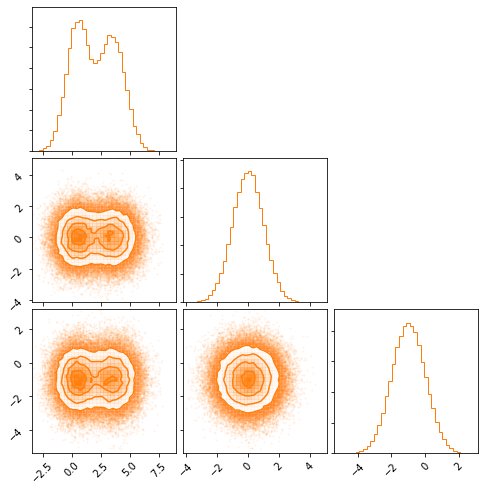

In [0]:
N = 100000
gen = lambda n : np.random.multivariate_normal([0.5, 0, -1], np.identity(3), size=n)
data1,data2,data3 = gen(N),gen(N),gen(N)
data2[:int(N/2),0] += np.random.normal(3, 0.5, size=int(N/2))
data3[int(N/2):,1] += np.random.normal(-3, 0.5, size=int(N/2))

# fig = corner.corner(data1, bins=40, color='tab:blue')
corner.corner(data2, bins=40, color='tab:orange')
# corner.corner(data3, bins=40, color='tab:green', fig=fig)
plt.show()

In [0]:
!pip install energyflow

In [0]:
import energyflow as ef

d = ef.datasets.qg_jets.load()

In [0]:
help(ef.datasets.qg_jets.load)

Help on function load in module energyflow.datasets.qg_jets:

load(num_data=100000, generator='pythia', pad=True, with_bc=False, cache_dir='~/.energyflow')
    Loads samples from the dataset (which in total is contained in twenty 
    files). Any file that is needed that has not been cached will be 
    automatically downloaded. Downloading a file causes it to be cached for
    later use. Basic checksums are performed.
    
    **Arguments**
    
    - **num_data** : _int_
        - The number of events to return. A value of `-1` means read in all
        events.
    - **generator** : _str_
        - Specifies which Monte Carlo generator the events should come from.
        Currently, the options are `'pythia'` and `'herwig'`.
    - **pad** : _bool_
        - Whether to pad the events with zeros to make them the same length.
        Note that if set to `False`, the returned `X` array will be an object
        array and not a 3-d array of floats.
    - **with_bc** : _bool_
        - Whe

In [1]:
housing.plot(kind='scatter', x='longitude', y='latitude',
            c='median_house_value', figsize=(10,10),
             cmap='jet', s=housing['population']/100, 
             label='population', alpha=0.35, colorbar=True
            )

import matplotlib.pyplot as plt
plt.gca().set_aspect(1)
plt.show()

NameError: name 'housing' is not defined

In [2]:


n = 3
means = np.random.uniform(-2, 2, n)
cov = np.random.uniform(0, 1, size=(n,n))
cov = np.maximum(np.mean([cov, cov.T], axis=0), np.identity(n)) 

big_data = np.random.multivariate_normal(mean=means, cov=cov.T, size=10000)
_ = corner.corner(big_data)

print(cov)
np.mean([cov, cov.T], axis=0)

cov

import pandas as pd
import seaborn as sns

iris = sns.load_dataset('iris')



sns.pairplot(iris)



import corner
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = None
for i,s in enumerate(iris.species.unique()):
    fig = corner.corner(iris[iris.species == s].drop('species', axis=1), fig=fig, bins=10, color=colors[i], range=list(zip(iris.min().values, iris.max().values))[:-1])
plt.show()

NameError: name 'np' is not defined